### Trajectory and Orientation: 


<img src="http://support.ptc.com/help/creo/creo_pma/usascii/part_modeling/part_modeling/images/image37.gif">

### 1. Importing Libs

In [81]:
# Matrix and Dataframe manipulation
import pandas as pd
import numpy as np
from pyquaternion import Quaternion
import math
import utm

In [2]:
# Visualization
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import make_subplots
init_notebook_mode(connected=True)

In [3]:
import pyvista
from pyvista import examples
from itkwidgets import view
from ipywidgets import interactive
import ipywidgets as widgets

### 2. Functions

In [4]:
def trace3D(PointCloud, color, size, name):
    trace = go.Scatter3d(
        x=PointCloud[:,0],
        y=PointCloud[:,1],
        z=PointCloud[:,2],
        name=name,
        mode='markers',
        marker=dict(
            size=size,
            line=dict(
                color=color,
                width=0.5
            ),
            opacity=0.8
        )
    )
    return trace

In [25]:
def fromRPYtoQuaternion(yaw, pitch, roll): # yaw (Z), pitch (Y), roll (X)

    # Abbreviations for the various angular functions
    cy = math.cos(yaw * 0.5)
    sy = math.sin(yaw * 0.5)
    cp = math.cos(pitch * 0.5)
    sp = math.sin(pitch * 0.5)
    cr = math.cos(roll * 0.5)
    sr = math.sin(roll * 0.5)
    
    w = ( cy * cp * cr) + (sy * sp * sr)
    x = (cy * cp * sr) - (sy * sp * cr)
    y = (sy * cp * sr) + (cy * sp * cr)
    z = (sy * cp * cr) - (cy * sp * sr)
    q = Quaternion([w,x,y,z]) 
    return q

### 3. Load Data

In [5]:
fileIMUGPS = 'Data_samples/GPS_IMU.csv'

In [6]:
dfIMUGPS = pd.read_csv(fileIMUGPS, sep=';')
dfIMUGPS.head()

,GPS_time(SoW),Latitud,Longitud,Altitud,X,Y,Z,Roll,Pitch,Heading,x_vel,y_vel,z_vel,x_acceleration,y_acceleration,z_acceleration,x_angular_rate,y_angular_rate,z_angular_rate,wander_angle
0,"146205,0","0,058953033744098056","-1,3358086558593238","1005,6015625","329334,1357625985","373483,1376809395","1005,6015625","0,0160264","-0,0347648","-0,5502994071795856","-0,00023393511946778744","-0,0012336354702711105","0,00018812160124070942","-0,0012790749315172434","-0,032843366265296936","0,004956238437443972","-0,0014341730857267976","0,059471096843481064","-0,022297486662864685","0,0"
1,"146205,00470000002","0,058953033744098056","-1,3358086558593238","1005,6015625","329334,1357625985","373483,1376809395","1005,6015625","0,016031","-0,0347647","-0,5502973","-0,0003881199227180332","-0,001227667322382331","0,0002112556539941579","0,0014078794047236443","-2,5804023607634008e-05","-0,00365342921577394","0,0022944575175642967","0,04206304997205734","-0,02973984181880951","0,0"
2,"146205,0097","0,058953033744024434","-1,3358086558597115","1005,6015625","329334,13576012943","373483,13768047694","1005,6015625","0,0160347","-0,0347647","-0,5502957","-0,00038826389936730266","-0,0012348662130534649","0,0001928161655087024","-0,006317539606243372","0,030872490257024765","0,000893652904778719","0,02218039147555828","0,009746220894157887","0,002594998339191079","0,0"
3,"146205,0147","0,058953033743803736","-1,3358086558608744","1005,6015625","329334,1357527235","373483,13767909055","1005,6015625","0,0160356","-0,034763","-0,5502987","-0,0002343267697142437","-0,0012036641128361225","0,00019710848573595285","0,015506944619119167","-0,015461028553545475","0,012599872425198555","0,01099455263465643","0,020928705111145973","0,006312591955065727","0,0"
4,"146205,0197","0,05895303374343651","-1,335808655862808","1005,6015014648438","329334,135740409","373483,1376767834","1005,6015014648438","0,0160375","-0,0347626","-0,5503039","-0,00031246605794876814","-0,0012818098766729236","0,00025992837618105114","0,011807162314653397","0,008526524528861046","0,006749377120286226","0,01223742589354515","0,0022746026515960693","-0,008584951050579548","0,0"


In [84]:
def lla_to_ecef_1(lat, lon, alt):
    # see http://www.mathworks.de/help/toolbox/aeroblks/llatoecefposition.html
    rad = np.float64(6378137.0)        # Radius of the Earth (in meters)
    f = np.float64(1.0/298.257223563)  # Flattening factor WGS84 Model
    cosLat = np.cos(lat)
    sinLat = np.sin(lat)
    FF     = (1.0-f)**2
    C      = 1/np.sqrt(cosLat**2 + FF * sinLat**2)
    S      = C * FF

    x = (rad * C + alt)*cosLat * np.cos(lon)
    y = (rad * C + alt)*cosLat * np.sin(lon)
    z = (rad * S + alt)*sinLat
    return x, y, z

In [87]:
lla_to_ecef_1(0.058953033744098056, -1.3358086558593238, 1005.6015625)

(1482699.1095257273, -6193120.4749965295, 373340.64880011574)

In [79]:
len(list(set(dfIMUGPS['GPS_time(SoW)'].values.tolist())))

286627

In [77]:
print(dfIMUGPS.shape)

(286627, 20)


### 4. Fixing cols type

In [7]:
# Fixing X, Y, and Z cols
colsXYZ = ['X','Y','Z']
dfIMUGPSFiltered = dfIMUGPS[colsXYZ]

for col in colsXYZ:
    data = dfIMUGPSFiltered[col].values.tolist()
    data = [float(val.replace(',','.')) for val in data]
    maxVal = max(data)
    dataX = [maxVal - val   for val in data]
    dfIMUGPSFiltered[col] = dataX
dfIMUGPSFiltered.dtypes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


X    float64
Y    float64
Z    float64
dtype: object

### 5. Getting Trajectory

In [8]:
x, y, z = dfIMUGPSFiltered['X'].values, dfIMUGPSFiltered['Y'].values,dfIMUGPSFiltered['Z'].values
Trajectory = np.ascontiguousarray(np.transpose(np.vstack([x,y,z])))
print(Trajectory.flags)
print(Trajectory.shape)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

(286627, 3)


In [9]:
dfIMUGPSFiltered.describe()

,X,Y,Z
count,286627.000000,286627.000000,286627.000000
mean,35.230528,219.054156,58.545317
std,48.798721,99.500770,28.297701
min,0.000000,0.000000,0.000000
25%,4.588674,124.457376,39.762390
50%,5.389475,284.095847,78.666443
75%,54.247106,285.389735,78.966370
max,156.239920,292.255811,78.986267


### 6. Orientation

In [12]:
colsRPY = ['Roll','Pitch','Heading']
Orientation = dfIMUGPS[colsRPY]

for col in colsRPY:
    data = Orientation[col].values.tolist()
    data = [float(val.replace(',','.')) for val in data]
    Orientation[col] = data
Orientation.dtypes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Roll       float64
Pitch      float64
Heading    float64
dtype: object

In [14]:
roll, pitch, yaw = Orientation['Roll'].values, Orientation['Pitch'].values,Orientation['Heading'].values
C_Orientation = np.ascontiguousarray(np.transpose(np.vstack([roll, pitch, yaw])))
print(C_Orientation.flags)
print(C_Orientation.shape)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

(286627, 3)


In [26]:
listQuaternions = [fromRPYtoQuaternion(yaw=C_Orientation[i,2], pitch=C_Orientation[i,1], roll=C_Orientation[i,0]) for i in range(C_Orientation.shape[0])]
print(listQuaternions[:10])

[Quaternion(0.9622460957333305, 0.002988279800854611, -0.01890393571938244, -0.27150720551048246), Quaternion(0.9622463756418711, 0.0029905264732322445, -0.018904508926608173, -0.27150614883965285), Quaternion(0.9622465873123337, 0.002992321753030076, -0.018905008819099824, -0.2715053440686638), Quaternion(0.9622461910730077, 0.0029929574150551804, -0.018904317640721525, -0.2715067895024708), Quaternion(0.9622454852179881, 0.002993876752534104, -0.018904390922214596, -0.27150927586999546), Quaternion(0.9622447146004648, 0.002994035156782122, -0.018904199639243946, -0.2715120185423653), Quaternion(0.9622433088507609, 0.0029935403695956113, -0.018902857118767817, -0.27151709942606245), Quaternion(0.9622416918166989, 0.002993500049008322, -0.018902064618465195, -0.27152288566592825), Quaternion(0.9622402053131005, 0.0029929138722133786, -0.01890158140794778, -0.2715281936849916), Quaternion(0.9622381458020266, 0.0029917765789718755, -0.01890033725263111, -0.2715355911995999)]


### 7. Visualization

In [69]:
init = 225482
totalPoints = 300
SubTrajectory = Trajectory[init:init+totalPoints,:]
Direction = listQuaternions[init:init+totalPoints]
#viewer = view(point_sets=[SubTrajectory])
#viewer

In [68]:
numpointsplot = 300
initSeg = 225482
maxslider = Trajectory.shape[0]   - numpointsplot                      
viewer = view(point_sets=[Trajectory[initSeg:initSeg+numpointsplot,:]])
def select_trajectory(selector=initSeg):
    viewer.point_sets = [Trajectory[selector:selector+numpointsplot,:]]
    
slider = interactive(select_trajectory, selector=(0, maxslider-1, 1))

widgets.VBox([viewer, slider])

In [70]:
def getAxis(origin, direction, color, width, length, size_end):
    normdirection = length * direction / np.linalg.norm(direction)
    end = origin + normdirection
    dx = [origin[0], end[0]]
    dy = [origin[1], end[1]]
    dz = [origin[2], end[2]]
    
    Eje = go.Scatter3d(
                x=dx, y=dy, z=dz,
                marker=dict(
                            size=size_end,
                            color=color
                ),
                line=dict(
                    color=color,
                    width=width
                )
    )    
    return Eje

In [71]:
def listCoordinateSystem(Trajectory, Direction, width, length, size_end):
    CoordinateSystem = []
    for i in range(Trajectory.shape[0]):
        origin = SubTrajectory[i,:]
        quat = Direction[i]
        
        directionX = np.array([1,0,0])
        directionY = np.array([0,1,0])
        directionZ = np.array([0,0,1])
        
        directionX_prime = quat.rotate(directionX)
        directionY_prime = quat.rotate(directionY)
        directionZ_prime = quat.rotate(directionZ)
        

        EjeX = getAxis(origin, directionX_prime, color='blue', width=width, length=length, size_end=size_end)
        EjeY = getAxis(origin, directionY_prime, color='red', width=width, length=length, size_end=size_end)
        EjeZ = getAxis(origin, directionZ_prime, color='green', width=width, length=length, size_end=size_end)
        
        CoordinateSystem.append(EjeX)
        CoordinateSystem.append(EjeY)
        CoordinateSystem.append(EjeZ)
    return CoordinateSystem

In [73]:
CoordinateSystems = listCoordinateSystem(SubTrajectory, Direction=Direction, width=1, length=0.001, size_end=4)

fig = make_subplots(rows=1, cols=1, specs=[[{'is_3d': True}]])

trace = trace3D(SubTrajectory, color='red', size=3, name='Trajectory')

for coordinatesystem in CoordinateSystems:
    fig.append_trace(coordinatesystem,1,1)

#fig.update_layout(scene=dict(aspectratio=dict(x=1, y=1, z=0.8), camera_eye=dict(x=1.2, y=1.2, z=0.6)))
iplot(fig, filename='simple-3d-scatter')

This is the format of your plot grid:
[ (1,1) scene1 ]



#### Load Lidar Data

In [75]:
dfCaptura1 = pd.read_csv('Data_samples/XYZ_&_RAW_ejemplo_2.csv', sep=';')
dfCaptura1.head()

,packet_time(SoW),block,Azimuth,channel,return,distance,Intensities,X,Y,Z,Unnamed: 10
0,"146796,000751356",0,"319,4653846153846",1,1,"44,425090000000004",33,"-11,389770049461404","41,2826880228365","-11,815310263927",NaN
1,"146796,000751356",0,"319,4653846153846",2,1,"51,87883000000001",31,"-10,955081623868878","49,4519522828174","-11,220675001146002",NaN
2,"146796,000751356",0,"319,4653846153846",3,1,"43,62379000000001",27,"-7,076040445300471","42,444112540509266","-7,173701059413001",NaN
3,"146796,000751356",0,"319,4653846153846",3,2,"45,33615",27,"-7,353795510069366","44,11016678636609","-7,455289585905001",NaN
4,"146796,000751356",0,"319,4653846153846",4,1,"48,501780000000004",30,"-5,339727516845177","47,906608734109746","-5,372794379856001",NaN


In [76]:
dfCaptura1.shape

(1283127, 11)

In [78]:
len(list(set(dfCaptura1['packet_time(SoW)'].values.tolist())))

3864

In [4]:
import time
import struct
import numpy as np
import re
from quanergyM8 import Quanergy_M8_Parser, MAGIC_SIGNATURE

qparse = Quanergy_M8_Parser()
_self = None
timeinit = time.time()

In [5]:
def pointcloud_callback(self):
    global listPoints
    global countscans
    global _self
    _self = self
    previntensities = self.prev_intensities[:self.prev_numpoints]
    prevpoints = self.prev_pointcloud[:self.prev_numpoints]
    listPoints.append(prevpoints.copy())

In [6]:
qparse.pointcloud_callback = pointcloud_callback
fileNameLiDAR = 'Data_samples/Data1.lid'

f = open(fileNameLiDAR, 'rb')
allData = f.read()
f.close()

In [7]:
listPoints = []
allpos = [m.start() for m in re.finditer(MAGIC_SIGNATURE, allData)]
validscans = 0
for pos in allpos:
    size, = struct.unpack('>I', allData[pos+4 : pos+8])
    if size > 5500 and size < 7500:
        pkt = allData[pos:pos+size]
        qparse.parse(pkt) 
        validscans = validscans + 1

print('Detected %d scans' % (len(allpos)))

Detected 772161 scans


In [8]:
print(validscans)
print(len(listPoints))

772161
7231


In [9]:
import pyvista
from pyvista import examples

from itkwidgets import view

from ipywidgets import interactive
import ipywidgets as widgets

In [11]:
point_set = Trajectory[:1000,:]
point_set.shape

(1000, 3)

In [12]:
# `view` returns the widget object
viewer = view(point_sets=[point_set])
viewer

Viewer(geometries=[], gradient_opacity=0.22, point_set_colors=array([[0.8392157, 0.       , 0.       ]], dtype…

In [12]:
# `view` returns the widget object
listPoints[0]
viewer = view(point_sets=[listPoints[0],listPoints[1]])

# Define a function to use with ipywidgets `interactive`
def select_cloud(selector=round(0.2*len(listPoints))):
    viewer.point_sets = [listPoints[selector], listPoints[selector+1]]
    
slider = interactive(select_cloud, selector=(0, len(listPoints)-2, 1))

widgets.VBox([viewer, slider])

In [43]:
import ipyvolume as ipv
import numpy as np
#pc = listPoints[5000]
#x, y, z = pc[:,0],pc[:,1],pc[:,2]
#pc = listPoints[5000]
x, y, z = dfIMUGPSFiltered['X'].values, dfIMUGPSFiltered['Y'].values,dfIMUGPSFiltered['Z'].values
Trajectory = np.transpose(np.vstack([x,y,z]))
print(Trajectory.shape)

(286627, 3)


In [38]:
ipv.quickscatter(x, y, z, size=1, marker="sphere")

[array([-0.16093828, -0.4504357 , -0.10596292], dtype=float32), array([57.434032, 59.482677,  0.      ], dtype=float32), array([72.17174 , 48.349857, -9.682677], dtype=float32)]
estimate: [ 0.33592515 -0.32438326  0.88426641  0.00164887]
# inliers: 376
[array([ 75.397255, -10.034387,  -8.477965], dtype=float32), array([70.31403  , 69.30182  , -5.5144525], dtype=float32), array([73.88446  ,  8.247295 , -4.1525345], dtype=float32)]
estimate: [-1.35132243e-02 -8.18500627e-04 -1.26673234e-03  9.99907555e-01]
# inliers: 7639
took iterations: 2 best model: [-1.35132243e-02 -8.18500627e-04 -1.26673234e-03  9.99907555e-01] explains: 7639


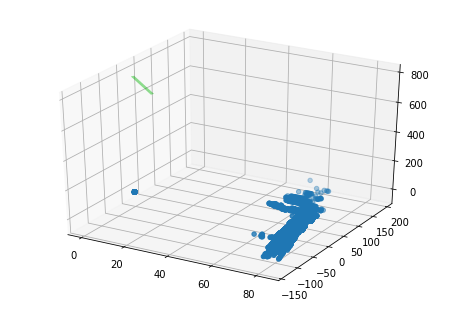

In [26]:
import numpy as np

def augment(xyzs):
    axyz = np.ones((len(xyzs), 4))
    axyz[:, :3] = xyzs
    return axyz

def estimate(xyzs):
    axyz = augment(xyzs[:3])
    return np.linalg.svd(axyz)[-1][-1, :]

def is_inlier(coeffs, xyz, threshold):
    return np.abs(coeffs.dot(augment([xyz]).T)) < threshold


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = mplot3d.Axes3D(fig)

def plot_plane(a, b, c, d):
    xx, yy = np.mgrid[:10, :10]
    return xx, yy, (-d - a * xx - b * yy) / c

n = listPoints[6310].shape[0]
max_iterations = 1000
goal_inliers = n * 0.3

# test data
xyzs = np.random.random((n, 3)) * 10
xyzs = listPoints[6310]

#xyzs[:50, 2:] = xyzs[:50, :1]
ax.scatter3D(xyzs.T[0], xyzs.T[1], xyzs.T[2])

# RANSAC
m, b = run_ransac(xyzs, estimate, lambda x, y: is_inlier(x, y, 1), 3, goal_inliers, max_iterations)
a, b, c, d = m
xx, yy, zz = plot_plane(a, b, c, d)
ax.plot_surface(xx, yy, zz, color=(0, 1, 0, 0.5))

plt.show()

In [22]:
xyzs.shape

(7748, 3)